## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

# Habib Khadri

# Nick Kirbabas

# Seerat Mutneja

# Sidhya Raman

# Douglas Riggs

In [2]:
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


# Andrew Yang

## Data Exploration & Cleaning

In [3]:
# nab the tn dataset and clean up columns regarding budget and gross profit
from datetime import datetime
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz").drop("id", axis = 1)
tn_df["production_budget"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["domestic_gross"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["worldwide_gross"].replace(["\$",","], "", regex = True, inplace = True)

# convert budget and profit columns to numeric
cols = ["production_budget","domestic_gross","worldwide_gross"]
tn_df[cols] = tn_df[cols].apply(pd.to_numeric)

# created new columns to grab date information (day, week of year, month, etc.)
tn_df["datetime"] = [datetime.strptime(d, "%b %d, %Y") for d in tn_df["release_date"]]
tn_df["release_weeknum"] = [d.isocalendar()[1] for d in tn_df["datetime"]]
tn_df["release_weekday"] = [d.weekday() for d in tn_df["datetime"]]
tn_df["release_month"] = [d.month for d in tn_df["datetime"]]
tn_df["release_year"] = [d.year for d in tn_df["datetime"]]

# calc movie seasonal info (came out on a weekend, calander season)
tn_df["weekend"]  = np.where((tn_df["release_weekday"]== 5) |
                                  (tn_df["release_weekday"]== 6),
                                    1, 0)   

tn_df.head(5)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009-12-18,51,4,12,2009,0
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011-05-20,20,4,5,2011,0
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019-06-07,23,4,6,2019,0
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015-05-01,18,4,5,2015,0
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017-12-15,50,4,12,2017,0


In [4]:
# null check
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   object        
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   datetime           5782 non-null   datetime64[ns]
 6   release_weeknum    5782 non-null   int64         
 7   release_weekday    5782 non-null   int64         
 8   release_month      5782 non-null   int64         
 9   release_year       5782 non-null   int64         
 10  weekend            5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(7), object(2)
memory usage: 474.4+ KB


In [5]:
# cleaned up dataset by gathering gross profit values and dropping NaN studios
bom_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
bom_df["foreign_gross"].replace(",","", regex = True, inplace = True)
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"])
bom_df["foreign_gross"].fillna(bom_df["foreign_gross"].median(), inplace = True)
bom_df["domestic_gross"].fillna(bom_df["domestic_gross"].median(), inplace = True)
bom_df.dropna(subset = ["studio"], inplace = True)
bom_df.head(5)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [6]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3382 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3382 non-null   float64
 3   foreign_gross   3382 non-null   float64
 4   year            3382 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 158.5+ KB


In [7]:
# Grab movie basics info along with average ratings for each from imdb dataset
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
    INNER JOIN movie_ratings USING("movie_id")
''',conn)
    
    
    #INNER JOIN known_for USING("movie_id")
    #INNER JOIN persons USING("person_id")

In [8]:
# Data cleaning to get genre count and runtime minutes
imdb_df.dropna(subset = ["genres"], inplace = True)
#imdb_df.dropna(subset = ["primary_profession"], inplace = True)
imdb_df["runtime_minutes"] = imdb_df["runtime_minutes"].fillna(imdb_df["runtime_minutes"].mean())
imdb_df["genres_list"] = [gs.split(",") for gs in imdb_df["genres"]]
imdb_df["genres_count"] = [len(gs) for gs in imdb_df["genres_list"]]
#imdb_df["prof_list"] = [gs.split(",") for gs in imdb_df["primary_profession"]]
imdb_df = imdb_df[imdb_df["runtime_minutes"] <= 300]
imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama",7.0,77,"[Action, Crime, Drama]",3
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama",7.2,43,"[Biography, Drama]",2
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama,6.9,4517,[Drama],1
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,94.732273,"Comedy,Drama",6.1,13,"[Comedy, Drama]",2
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy",6.5,119,"[Comedy, Drama, Fantasy]",3
...,...,...,...,...,...,...,...,...,...,...
73850,tt9913056,Swarm Season,Swarm Season,2019,86.000000,Documentary,6.2,5,[Documentary],1
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.000000,Documentary,6.2,6,[Documentary],1
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.000000,"Drama,Family",8.7,136,"[Drama, Family]",2
73853,tt9914642,Albatross,Albatross,2017,94.732273,Documentary,8.5,8,[Documentary],1


In [9]:
# merging datasets imdb (cleaned) and bom (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c = imdb_df.merge(bom_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["title","year"])
imdb_df_c.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,"[Action, Crime, Drama]",3,Wazir,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,"[Adventure, Drama, Romance]",3,On the Road,IFC,744000.0,8000000.0,2012
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"[Adventure, Comedy, Drama]",3,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"[Action, Crime, Drama]",3,A Walk Among the Tombstones,Uni.,26300000.0,26900000.0,2014
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,"[Action, Adventure, Sci-Fi]",3,Jurassic World,Uni.,652300000.0,1019.4,2015


In [10]:
# merging datasets imdb_c (cleaned) and tn (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c2 = imdb_df_c.merge(tn_df, how = "inner", 
                             left_on = ["primary_title", "start_year"], 
                             right_on = ["movie","release_year"])

# create worldwide gross, adjusted for production budge
imdb_df_c2["adjusted_worldwide"] = imdb_df_c2["worldwide_gross"] - imdb_df_c2["production_budget"]

# it's beautiful
imdb_df_c2.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,production_budget,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"[Adventure, Comedy, Drama]",3,...,91000000,58236838,187861183,2013-12-25,52,2,12,2013,0,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"[Action, Crime, Drama]",3,...,28000000,26017685,62108587,2014-09-19,38,4,9,2014,0,34108587
2,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,"[Action, Adventure, Sci-Fi]",3,...,215000000,652270625,1648854864,2015-06-12,24,4,6,2015,0,1433854864
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,"[Comedy, Drama]",2,...,45000000,13109815,21544732,2011-10-28,43,4,10,2011,0,-23455268
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",5.1,28570,"[Comedy, Family]",2,...,30000000,44338224,54052249,2012-04-13,15,4,4,2012,0,24052249


In [11]:
imdb_df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1041
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            1042 non-null   object        
 1   primary_title       1042 non-null   object        
 2   original_title      1042 non-null   object        
 3   start_year          1042 non-null   int64         
 4   runtime_minutes     1042 non-null   float64       
 5   genres              1042 non-null   object        
 6   averagerating       1042 non-null   float64       
 7   numvotes            1042 non-null   int64         
 8   genres_list         1042 non-null   object        
 9   genres_count        1042 non-null   int64         
 10  title               1042 non-null   object        
 11  studio              1042 non-null   object        
 12  domestic_gross_x    1042 non-null   float64       
 13  foreign_gross       1042 non-null   float64     

## EDA

In [12]:
# plots the number of movies that have various categories
# genre_Dict = {}
# for genres in tmdb_df["genre_ids"]:
#     for g in genres.replace("[","").replace("]","").split(", "):
#         if g not in genre_Dict:
#             genre_Dict[g] = 1
#         else:
#             genre_Dict[g] += 1


# genre_Dict["0"] = genre_Dict.pop("")
# fig, ax = plt.subplots()
# ax.bar(genre_Dict.keys(),genre_Dict.values())
# ax.set_xlabel("Genre")
# ax.set_ylabel("Count")
# plt.xticks(rotation = 90) 

In [13]:
# Shows top 5 languages in movies
# org_langs_tmdb = tmdb_df["original_language"].value_counts()[:5]
# fig, ax = plt.subplots()
# ax.bar(org_langs_tmdb.index,org_langs_tmdb)

In [14]:
# boxoffice_dist = [int(b.replace(",","")) for b in rt_movie_df["box_office"] if isinstance(b, str)]
# fig, ax = plt.subplots()
# ax.hist(boxoffice_dist, bins = 25)
# ax.set_title("Distribution of Box Office Earnings")
# ax.set_xlabel("Box Office Earnings")
# ax.set_ylabel("Frequency")
# plt.xticks(rotation = 90) 
# fig.show()

<ipython-input-15-a8ec1373fbc0>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


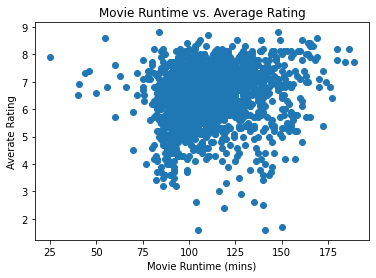

In [15]:
fig, ax = plt.subplots()
ax.scatter(imdb_df_c["runtime_minutes"], imdb_df_c["averagerating"])
ax.set_title("Movie Runtime vs. Average Rating")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Averate Rating")
fig.show()

Text(0, 0.5, 'Frequency')

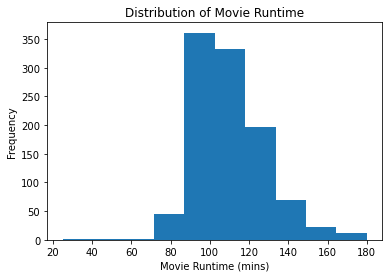

In [16]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["runtime_minutes"])
ax.set_title("Distribution of Movie Runtime")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Frequency")
#fig.show()

Text(0, 0.5, 'Frequency')

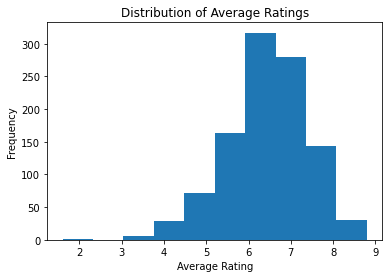

In [17]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["averagerating"])
ax.set_title("Distribution of Average Ratings")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Relative Frequency')

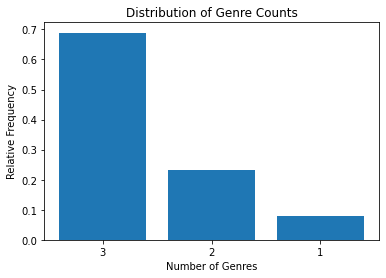

In [18]:
g_count = imdb_df_c2["genres_count"].value_counts(normalize  = True)
labs = [str(x) for x in g_count.index]
fig, ax = plt.subplots()
ax.bar(labs, g_count)
ax.set_title("Distribution of Genre Counts")
ax.set_xlabel("Number of Genres")
ax.set_ylabel("Relative Frequency")

## Hypothesis Testing

### Runtime and Adjusted Worldwide Gross

H0: Movies longer than 90 minutes do no make more worldwide gross revenue than those shorter than 90 minutes.

Ha: Movies longer than 90 minutes do make more worldwide gross revenue than those shorter than 90 minutes.

In [19]:
import scipy.stats as stats

In [20]:
long_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]>= 90]
long_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,production_budget,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"[Adventure, Comedy, Drama]",3,...,91000000,58236838,187861183,2013-12-25,52,2,12,2013,0,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"[Action, Crime, Drama]",3,...,28000000,26017685,62108587,2014-09-19,38,4,9,2014,0,34108587
2,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,"[Action, Adventure, Sci-Fi]",3,...,215000000,652270625,1648854864,2015-06-12,24,4,6,2015,0,1433854864
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,"[Comedy, Drama]",2,...,45000000,13109815,21544732,2011-10-28,43,4,10,2011,0,-23455268
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",5.1,28570,"[Comedy, Family]",2,...,30000000,44338224,54052249,2012-04-13,15,4,4,2012,0,24052249


In [21]:
short_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]< 90]
short_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,production_budget,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,adjusted_worldwide
20,tt0464154,Piranha 3D,Piranha 3D,2010,88.0,"Comedy,Horror",5.4,81327,"[Comedy, Horror]",2,...,24000000,25003155,83660160,2010-08-20,33,4,8,2010,0,59660160
60,tt0822847,Priest,Priest,2011,87.0,"Action,Adventure,Fantasy",5.7,108320,"[Action, Adventure, Fantasy]",3,...,60000000,29136626,84154026,2011-05-13,19,4,5,2011,0,24154026
68,tt0873886,Red State,Red State,2011,88.0,"Action,Crime,Horror",6.2,59266,"[Action, Crime, Horror]",3,...,4000000,1065429,1983596,2011-09-23,38,4,9,2011,0,-2016404
69,tt0878835,Please Give,Please Give,2010,87.0,"Comedy,Drama",6.6,10652,"[Comedy, Drama]",2,...,3000000,4033574,4570178,2010-04-30,17,4,4,2010,0,1570178
128,tt1075747,Jonah Hex,Jonah Hex,2010,81.0,"Action,Drama,Fantasy",4.7,51860,"[Action, Drama, Fantasy]",3,...,47000000,10547117,11022696,2010-06-18,24,4,6,2010,0,-35977304


In [22]:
results = stats.ttest_ind(long_movies["adjusted_worldwide"], 
                          short_movies["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 2.0567962886580027.
The p-value is 0.019977415485442317.
We reject the null hypothesis at an alpha level of 0.05.


In [23]:
a = long_movies["adjusted_worldwide"]
b = short_movies["adjusted_worldwide"]

stats.t.interval(confidence=0.95, loc=a.mean(), 
                 df=len(a)-1, 
                 scale=stats.sem(a)) 

(111916701.00077155, 138827863.87922844)

In [24]:
stats.t.interval(confidence=0.95, loc=b.mean(), 
                 df=len(b)-1, 
                 scale=stats.sem(b)) 

(45012616.07252369, 112509744.25356328)

### Genre Count and Adjusted Worldwide Gross

H0: Movies that occupy three genres do not have higher worldwide gross than those with only one or two genres.

Ha: Movies that occupy three genres do have higher worldwide gross than those with only one or two genres.

In [25]:
genres_3 = imdb_df_c2[imdb_df_c2["genres_count"]== 3]
genres_1or2 = imdb_df_c2[imdb_df_c2["genres_count"]!= 3]

In [26]:
results = stats.ttest_ind(genres_3["adjusted_worldwide"], 
                          genres_1or2["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 5.972650069299291.
The p-value is 1.6004895566572263e-09.
We reject the null hypothesis at an alpha level of 0.05.


### Movie Budget and Adjusted Worldwide Gross

H0: Movies with higher budgets do not have larger worldwide gross than those with smaller budgets on average.

Ha: Movies with higher budgets do have larger worldwide gross than those with smaller budgets.

<AxesSubplot:>

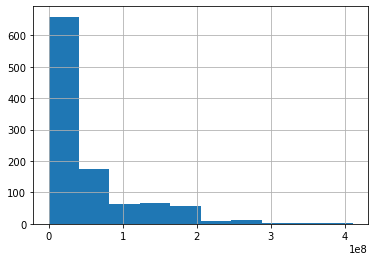

In [27]:
imdb_df_c2["production_budget"].hist()

Text(0, 0.5, 'Worldwide Gross ($)')

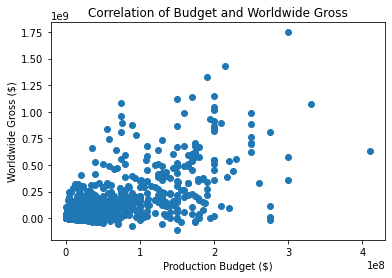

In [28]:
fig, ax = plt.subplots()
ax.scatter(imdb_df_c2["production_budget"], imdb_df_c2["adjusted_worldwide"])
ax.set_title("Correlation of Budget and Worldwide Gross")
ax.set_xlabel("Production Budget ($)")
ax.set_ylabel("Worldwide Gross ($)")

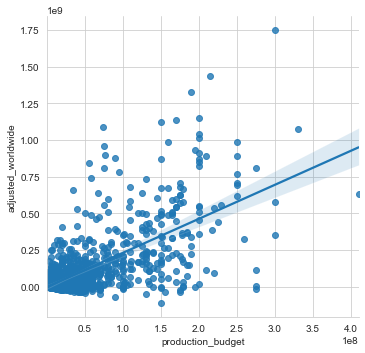

In [29]:
import seaborn as sns
sns.set_style('whitegrid')
sns.lmplot(x ='production_budget', y ='adjusted_worldwide', data = imdb_df_c2)

In [30]:
high_prod = imdb_df_c2[imdb_df_c2["production_budget"] >= imdb_df_c2["production_budget"].median()]
low_prod = imdb_df_c2[imdb_df_c2["production_budget"] < imdb_df_c2["production_budget"].median()]

In [31]:
results = stats.ttest_ind(high_prod["adjusted_worldwide"], low_prod["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 13.44147474533769.
The p-value is 2.1399824760435253e-38.
We reject the null hypothesis at an alpha level of 0.05.


### Linear Modeling of Adjusted Worldwide Gross

By developing a linear model, we can see if the variables we select are significant in determining adjusted worldwide gross. In addition, we can see the relationship between variables and the predicted result.

In [12]:
# if only we could get statsmodels to work
# this is where that fancy shmancy model would go
#import statsmodels.api as sm